In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
%matplotlib inline
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential, load_model, clone_model
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11224065625892835177
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2065747148
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17092080774634717858
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
df = pd.read_csv('Movies-Poster_Dataset-master/train.csv')

In [3]:
df.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
df['Id'] = df['Id'].apply(lambda x: x + '.jpg')

In [5]:
df.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425.jpg,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0085549.jpg,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,tt0086465.jpg,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0086567.jpg,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,tt0086034.jpg,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
df.isnull().sum(axis=0)

Id             0
Genre          0
Action         0
Adventure      0
Animation      0
Biography      0
Comedy         0
Crime          0
Documentary    0
Drama          0
Family         0
Fantasy        0
History        0
Horror         0
Music          0
Musical        0
Mystery        0
N/A            0
News           0
Reality-TV     0
Romance        0
Sci-Fi         0
Short          0
Sport          0
Thriller       0
War            0
Western        0
dtype: int64

In [7]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [8]:
train_df.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
3889,tt0300556.jpg,"['Action', 'Adventure', 'Sci-Fi']",1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
877,tt0095360.jpg,"['Documentary', 'Biography', 'Music']",0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
624,tt0092563.jpg,"['Horror', 'Mystery', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2957,tt0160401.jpg,"['Crime', 'Thriller', 'Drama']",0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
927,tt0095186.jpg,"['Comedy', 'Drama', 'Romance']",0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [9]:
df.columns

Index(['Id', 'Genre', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'N/A', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [10]:
augmentation = ImageDataGenerator(rescale=1/255)

train_images = augmentation.flow_from_dataframe(
    dataframe=train_df,
    directory='Movies-Poster_Dataset-master/Images/',
    x_col= 'Id',
    y_col= ['Action', 'Adventure', 'Animation', 'Comedy', 'History',
            'Horror', 'Romance', 'Sci-Fi', 'Thriller', 'War',],
    target_size=(471, 300),
    class_mode='raw',
    shuffle=True,
    batch_size=32
)

test_images = augmentation.flow_from_dataframe(
    dataframe=test_df,
    directory='Movies-Poster_Dataset-master/Images/',
    x_col='Id',
    y_col= ['Action', 'Adventure', 'Animation', 'Comedy', 'History', 
            'Horror', 'Romance', 'Sci-Fi', 'Thriller', 'War',],
    target_size=(471, 300),
    class_mode='raw',
    shuffle=True,
    batch_size=32
)

Found 6528 validated image filenames.
Found 726 validated image filenames.


In [11]:
# Create a model
tf.random.set_seed(42)

# Create inputs 
inputs = layers.Input(shape=(471, 300, 3))

# Pass the inputs to the backbone
backbone = hub.KerasLayer('https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2', trainable=False)
x = backbone(inputs)

# Create an outputs
outputs = layers.Dense(10, activation='sigmoid')(x)

# Pass the inputs and output to the model
model_1 = tf.keras.Model(inputs, outputs)

In [12]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 471, 300, 3)]     0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


In [13]:
model_1.compile(loss='binary_crossentropy',
                metrics='accuracy',
                optimizer=Adam())

# Create callbacks
tensorboard = tf.keras.callbacks.TensorBoard('poster_movie_1/model_1')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='poster_movie/model_1/model_1.ckpt',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                save_weights_only=False)

In [14]:
model_1.fit(train_images,
            epochs=10,
            validation_data=test_images,
            callbacks=[tensorboard, checkpoint])

Epoch 1/10
204/204 [==============================] - ETA: 0s - loss: 0.3011 - accuracy: 0.3869

INFO:tensorflow:Assets written to: poster_movie/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: poster_movie/model_1\model_1.ckpt\assets


204/204 [==============================] - 94s 398ms/step - loss: 0.3011 - accuracy: 0.3869 - val_loss: 0.2684 - val_accuracy: 0.4174
Epoch 2/10
204/204 [==============================] - ETA: 0s - loss: 0.2610 - accuracy: 0.4344

INFO:tensorflow:Assets written to: poster_movie/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: poster_movie/model_1\model_1.ckpt\assets


204/204 [==============================] - 47s 231ms/step - loss: 0.2610 - accuracy: 0.4344 - val_loss: 0.2610 - val_accuracy: 0.4421
Epoch 3/10
204/204 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.4410

INFO:tensorflow:Assets written to: poster_movie/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: poster_movie/model_1\model_1.ckpt\assets


204/204 [==============================] - 47s 230ms/step - loss: 0.2514 - accuracy: 0.4410 - val_loss: 0.2588 - val_accuracy: 0.4256
Epoch 4/10
204/204 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.4580

INFO:tensorflow:Assets written to: poster_movie/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: poster_movie/model_1\model_1.ckpt\assets


204/204 [==============================] - 49s 240ms/step - loss: 0.2451 - accuracy: 0.4580 - val_loss: 0.2575 - val_accuracy: 0.4408
Epoch 5/10
204/204 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.4591

INFO:tensorflow:Assets written to: poster_movie/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: poster_movie/model_1\model_1.ckpt\assets


204/204 [==============================] - 48s 233ms/step - loss: 0.2404 - accuracy: 0.4591 - val_loss: 0.2552 - val_accuracy: 0.4490
Epoch 6/10
204/204 [==============================] - 39s 191ms/step - loss: 0.2363 - accuracy: 0.4606 - val_loss: 0.2553 - val_accuracy: 0.4504
Epoch 7/10
204/204 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.4671 ETA: 1s - loss: 0.2330 - ac

INFO:tensorflow:Assets written to: poster_movie/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: poster_movie/model_1\model_1.ckpt\assets


204/204 [==============================] - 47s 232ms/step - loss: 0.2330 - accuracy: 0.4671 - val_loss: 0.2552 - val_accuracy: 0.4477
Epoch 8/10
204/204 [==============================] - 41s 200ms/step - loss: 0.2302 - accuracy: 0.4706 - val_loss: 0.2553 - val_accuracy: 0.4490
Epoch 9/10
204/204 [==============================] - 39s 191ms/step - loss: 0.2280 - accuracy: 0.4741 - val_loss: 0.2565 - val_accuracy: 0.4408
Epoch 10/10
204/204 [==============================] - 39s 191ms/step - loss: 0.2253 - accuracy: 0.4758 - val_loss: 0.2579 - val_accuracy: 0.4573


In [38]:
# Create model 2
tf.random.set_seed(42)

# Create inputs
inputs = layers.Input(shape=(471, 300, 3))

# Create layers
x = layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)

x = layers.Dense(units=128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(units=128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation='sigmoid')(x)

# Create a model
model_2 = tf.keras.Model(inputs, outputs)

In [39]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 471, 300, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 469, 298, 16)      448       
                                                                 
 batch_normalization_8 (Batc  (None, 469, 298, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 234, 149, 16)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 234, 149, 16)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 232, 147, 32)      4640

In [40]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                metrics='accuracy',
                optimizer=Adam())

# Create callbacks
tensorboard = tf.keras.callbacks.TensorBoard('poster_movie_1/model_2')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='poster_movie/model_2/model_2.ckpt',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                save_weights_only=False)


model_2.fit(train_images,
            epochs=10,
            validation_data=(test_images))

Epoch 1/10
204/204 [==============================] - 79s 373ms/step - loss: 0.7066 - accuracy: 0.1766 - val_loss: 2.6891 - val_accuracy: 0.3719
Epoch 2/10
204/204 [==============================] - 38s 188ms/step - loss: 0.3896 - accuracy: 0.3006 - val_loss: 0.3552 - val_accuracy: 0.2590
Epoch 3/10
204/204 [==============================] - 38s 188ms/step - loss: 0.3366 - accuracy: 0.3559 - val_loss: 0.3238 - val_accuracy: 0.3030
Epoch 4/10
204/204 [==============================] - 38s 188ms/step - loss: 0.3248 - accuracy: 0.3709 - val_loss: 0.3285 - val_accuracy: 0.3196
Epoch 5/10
204/204 [==============================] - 38s 188ms/step - loss: 0.3163 - accuracy: 0.3673 - val_loss: 0.3197 - val_accuracy: 0.3981
Epoch 6/10
204/204 [==============================] - 38s 187ms/step - loss: 0.3113 - accuracy: 0.3755 - val_loss: 0.3178 - val_accuracy: 0.3430
Epoch 7/10
204/204 [==============================] - 40s 195ms/step - loss: 0.3070 - accuracy: 0.3853 - val_loss: 0.3065 - val_ac

In [32]:
!nvidia-smi

Tue Nov 16 11:57:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.11       Driver Version: 471.11       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8     1W /  N/A |   2516MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
def predict_img(path, model):
    img = tf.keras.preprocessing.image.load_img(path, target_size=(471, 300, 3))
    plt.figure(figsize=(6, 10))
    plt.imshow(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    label = ['Action', 'Adventure', 'Animation', 'Comedy', 'History', 
            'Horror', 'Romance', 'Sci-Fi', 'Thriller', 'War',]
    img = np.expand_dims(img, axis=0)
    pred_1 = label[(np.argsort(model.predict(img))[0][-1])]
    pred_2 = label[(np.argsort(model.predict(img))[0][-2])]
    pred_3 = label[(np.argsort(model.predict(img))[0][-3])]
    plt.title(f'Genre : {pred_1}, {pred_2}, {pred_3}', fontsize=15)
    plt.axis('off')

In [28]:
label = ['Action', 'Adventure', 'Animation', 'Comedy', 'History', 
            'Horror', 'Romance', 'Sci-Fi', 'Thriller', 'War',]

In [29]:
from sklearn.preprocessing import LabelBinarizer

In [30]:
lb = LabelBinarizer()
lb.fit_transform(label)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

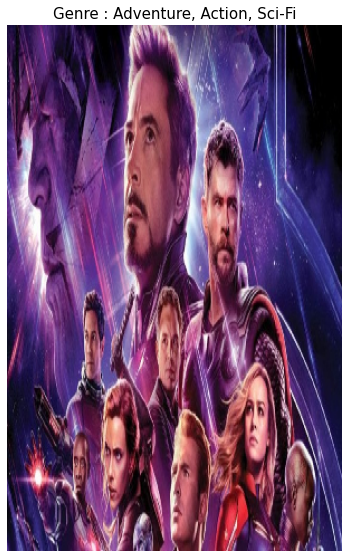

In [31]:
predict_img('Movies-Poster_Dataset-master/endgame.jpg', model)

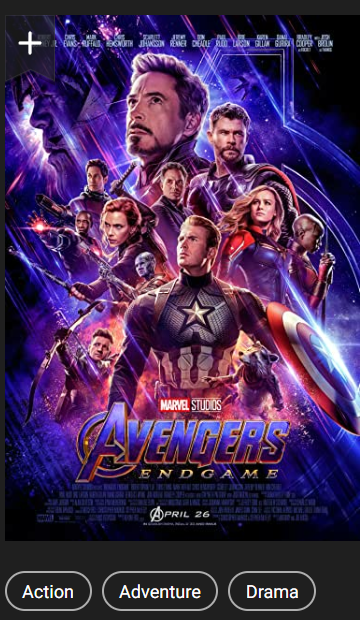

In [41]:
model_2.save('model_2')

INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


In [42]:
model_conv = load_model('model_2/')

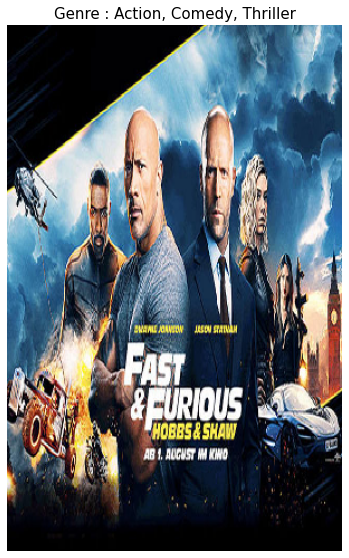

In [43]:
predict_img('Movies-Poster_Dataset-master/fast.jpg', model_conv)

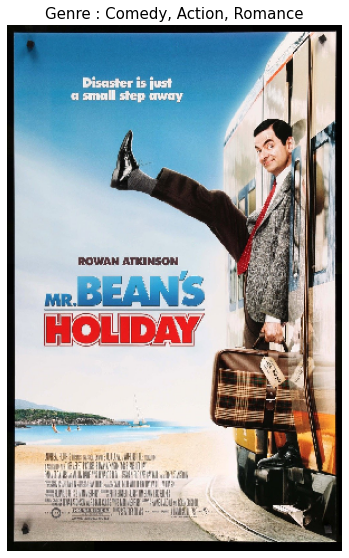

In [44]:
predict_img('mrbean_sholiday_2007_original_film_art_5000x.jpg', model_conv)

In [29]:
model_1.save('model_1')

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


In [2]:
model = load_model('model_1/')

In [ ]:
model.predict

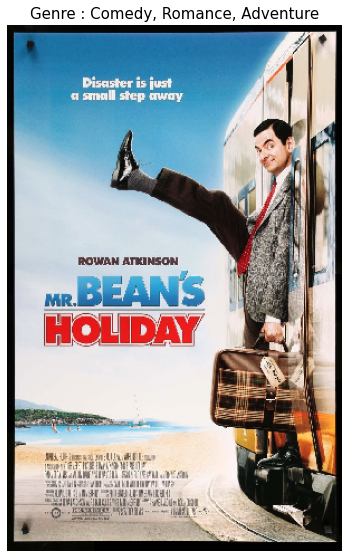

In [32]:
predict_img('mrbean_sholiday_2007_original_film_art_5000x.jpg', model)

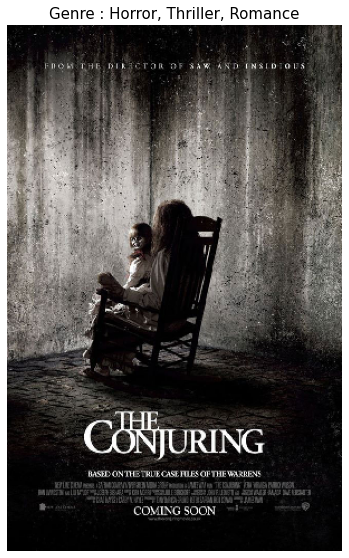

In [33]:
predict_img('conjuring-intl-poster-1.jpg', model)

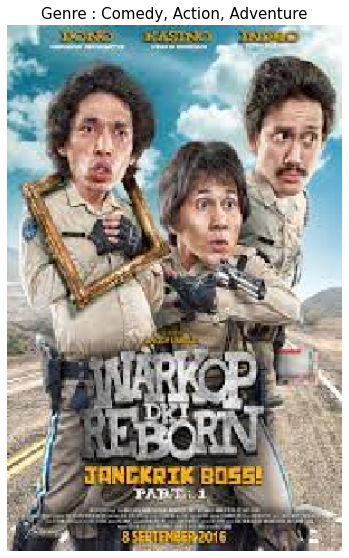

In [34]:
predict_img('warkop.jpg', model)

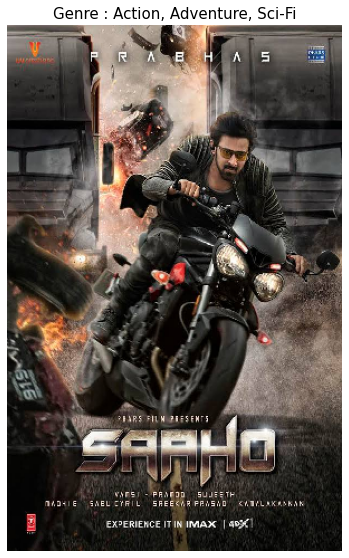

In [35]:
predict_img('Movies-Poster_Dataset-master/saaho.jpg', model)